In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
import datetime
from implementations import *
from helpers import *
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
# Github does not accept files above 100mb and test.csv is 104mb
# thus we upload zip whith test.csv which needs to be extracted
with zipfile.ZipFile("../data/test.csv.zip","r") as zip_ref:
    zip_ref.extractall("../data/")

In [3]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
y, x, ids = load_csv_data(DATA_TRAIN_PATH)

# General comparison of method on raw data (Nan)

In [4]:
#Let's modify the data: replace -999 by -9
x_99 = x
np.putmask(x_99, x_99==-999, -9)

#Split the data
ratio = 0.1
y = np.reshape(y, (len(y), 1))
x_train, x_test, y_train, y_test = split_data(x_99, y, ratio)

#Create Feature Matrix
tx_train_99 = np.c_[np.ones((y_train.shape[0], 1)), x_train]
tx_test_99 = np.c_[np.ones((y_test.shape[0], 1)), x_test]

#Compute rmse and accuracy of different method without optimization
print("RMSEs:")

#Least squares
print("\t*** LS ****")
w_LS, rmse_tr = least_squares(y_train, tx_train_99)
rmse_te = compute_RMSE(y_test, tx_test_99, w_LS)
print(rmse_te)
print(rmse_tr)

#Gradient Descent
print("\t*** GS ****")
gamma = 0.00001
max_iters = 5
initial_w  = np.zeros((tx_train_99.shape[1],1))
w_GD, rmse_tr_GD, = least_squares_GD(y_train, tx_train_99, initial_w, max_iters, gamma)
rmse_te_GD = compute_RMSE(y_test, tx_test_99, w_GD)
print(rmse_te_GD)
print(rmse_tr_GD)

#Newton
print("\t*** N ****")
gamma = 0.00002
max_iters = 5
lambd = 0.5
initial_w  = np.zeros((tx_train_99.shape[1],1))
w_N, rmse_tr_N = learning_by_newton_method(y_train, tx_train_99, initial_w, max_iters, gamma)
rmse_te_N = compute_RMSE(y_test, tx_test_99, w_N)
print(rmse_te_N)
print(rmse_tr_N)

#Mean of 10 folds least squares
print("\t*** CLS ****")
k_folds = 10
seed = 2
w_LS_folds, rmse_tr_CLS, rmse_te_CLS = cross_validation_LS(y, x_99, k_folds, seed)

#Mean of weights along folds
w_CLS = w_LS_folds.mean(axis=0)
w_CLS = np.reshape(w_CLS, (tx_train_99.shape[1], 1))
test_mse_CLS_mean = compute_loss(y_test, tx_test_99, w_CLS)
train_mse_CLS_mean = compute_loss(y_train, tx_train_99, w_CLS)
rmse_te_CLS_mean = np.sqrt(2*test_mse_CLS_mean)
rmse_tr_CLS_mean = np.sqrt(2*train_mse_CLS_mean)
print("-mean weights:")
print(rmse_te_CLS_mean)
print(rmse_tr_CLS_mean)

#Best weights along folds
w_CLS_best = w_LS_folds[np.argmin(rmse_te_CLS)]
w_CLS_best = np.reshape(w_CLS_best, (tx_train_99.shape[1], 1))
test_mse_CLS_best = compute_loss(y_test, tx_test_99, w_CLS_best)
train_mse_CLS_best = compute_loss(y_train, tx_train_99, w_CLS_best)
rmse_te_CLS_best = np.sqrt(2*test_mse_CLS_best)
rmse_tr_CLS_best = np.sqrt(2*train_mse_CLS_best)
print("-best weights:")
print(rmse_te_CLS_best)
print(rmse_tr_CLS_best)

#Penalized Regression
lambd = 0.5
gamma = 0.00002
max_iters = 5
print("\t**** Penalized *******")
initial_w  = np.zeros((tx_train_99.shape[1],1))
w_reg, rmse_tr_reg = reg_logistic_regression(y_train, tx_train_99, lambd, initial_w, max_iters, gamma)
rmse_te_reg = compute_RMSE(y_test, tx_test_99, w_reg)
print(rmse_te_reg)
print(rmse_tr_reg)

#Accuracy measure
print("\n")
print("ratio of well-classified over total predictions: ")

y_pred_LS = predict_labels(w_CLS, tx_test_99)
f1_CLS = sum(abs(y_test-y_pred_LS))/(2*len(y_pred_LS))
print("F1 CV folds Least Squares: {l}".format(l=1-f1_CLS))

y_pred_GS = predict_labels(w_GD, tx_test_99)
f1_GS = sum(abs(y_test-y_pred_GS))/(2*len(y_pred_GS))
print("F1 Gradient Descent: {l}".format(l=1-f1_GS))

y_pred_N = predict_labels(w_N, tx_test_99)
f1_N = sum(abs(y_test-y_pred_N))/(2*len(y_pred_N))
print("F1 Newton Method: {l}".format(l=1-f1_N))

y_pred_PR = predict_labels(w_reg, tx_test_99)
f1_PR = sum(abs(y_test-y_pred_PR))/(2*len(y_pred_PR))
print("F1 Penalized Regression: {l}".format(l=1-f1_PR))

RMSEs:
	*** LS ****
0.824319370683
0.826956343995
	*** GS ****
0.928404908633
0.928677901986
	*** N ****
0.999809002735
0.999810306918
	*** CLS ****
-mean weights:
0.823861760302
0.82732031017
-best weights:
0.823867919796
0.827321865538
	**** Penalized *******
0.999808995056
0.999810331214


ratio of well-classified over total predictions: 
F1 CV folds Least Squares: [ 0.74488444]
F1 Gradient Descent: [ 0.69016889]
F1 Newton Method: [ 0.68243556]
F1 Penalized Regression: [ 0.68244]


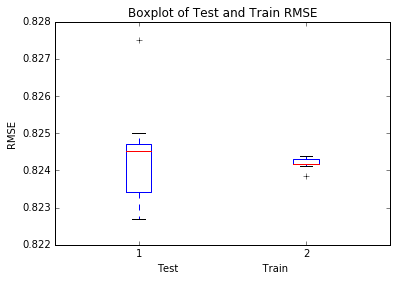

In [5]:
#plot variance and mean of test/train error of Least squares
plt.boxplot([rmse_te_CLS, rmse_tr_CLS])
plt.xlabel("Test                           Train")
plt.ylabel("RMSE")
plt.title("Boxplot of Test and Train RMSE")

# Ridge and Least square comparison on polynomial degree 3

In [6]:
#***** RIDGE AND LEAST SQUARE ON POLYNOMIAL BASIS FUNCTION DATASET

#Let's replace the -999 by Nan to avoid computation while computing the power 3
x_nan = x.copy()
np.putmask(x_nan, x_nan==-999, np.nan)
x_square = np.zeros((x_nan.shape[0], 3*x_nan.shape[1]))

#Let's build a matrix using a polynomial basis function (power 3)
for column in range(0,x_nan.shape[1]):
    x_square[:, column] = x_nan[:, column]
    x_square[:, column+x_nan.shape[1]] = np.multiply(x_nan[:,column], x_nan[:,column])
    x_square[:, column+2*x_nan.shape[1]] = np.multiply(np.multiply(x_nan[:,column], x_nan[:,column]), x_nan[:,column])
#put back -9 instead of Nan
x_square[np.isnan(x_square)]=-9

ratio = 0.3
y = np.reshape(y, (len(y), 1))
x_train, x_test, y_train, y_test = split_data(x_square, y, ratio)

#tx_train_square, m, s = standardize(x_train)
#tx_test_square, m, s = standardize(x_test)

tx_train_square = np.c_[np.ones((y_train.shape[0], 1)), x_train]
tx_test_square = np.c_[np.ones((y_test.shape[0], 1)), x_test]
w = np.ones((tx_train_square.shape[1], 1))

#Calculate accuracy with a least square regression
w_LS_pow3, rmse_LS_pow3 = least_squares(y_train, tx_train_square)
y_pred_LS = predict_labels(w_LS_pow3, tx_test_square)
f1_LS_pow3 = sum(abs(y_test-y_pred_LS))/(2*len(y_pred_LS))
print("Accuracy score for Least Squares: {f}".format(f=1-f1_LS_pow3))

#calculate accuracy for different lambdas (use cross_validation_ridge() for cross folds)
lambds = np.logspace(-6, -5, 50)
best_f1 = 1000
best_lamb = 0
k_folds = 5
seed = 1
f1_mean = []
f1_std = []
weights_ridge = np.zeros((tx_train_square.shape[1], 1))

#Find the best lambda on the interval
for lamb in lambds:
    w_rid, r = ridge_regression(y_train, tx_train_square, lamb)
    y_pred_rid = predict_labels(w_rid, tx_test_square)
    f1_rid = sum(abs(y_test-y_pred_rid))/(2*len(y_pred_rid))
    weights_ridge = np.hstack((weights_ridge, w_rid))
    if f1_rid < best_f1:
        best_lamb = lamb
        best_f1 = f1_rid

print("The best lmabda for Ridge Regression is {bl} with accuracy of {f}".format(bl=best_lamb, f=1-best_f1))

Accuracy score for Least Squares: [ 0.78124]
The best lmabda for Ridge Regression is 1e-06 with accuracy of [ 0.78096571]


# Ridge regression and least square comparison on polynomial degree 9

Accuracy score for LS: [ 0.810885]
the best lmabda is 2.0565123083486514e-06 with accuracy of [ 0.81492]


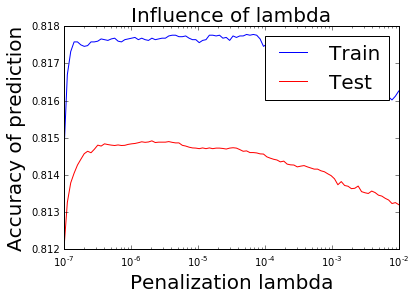

In [7]:
#***** RIDGE AND LEAST SQUARE ON POLYNOMIAL BASIS FUNCTION DATASET
#************ POWER 9 **********************

#Let's replace the -999 by Nan to avoid computation while computing the power 3
x_nan = x.copy()
np.putmask(x_nan, x_nan==-999, np.nan)
degree = 9
x_fifth = np.zeros((x_nan.shape[0], degree*x_nan.shape[1]))

#Let's build a matrix using a polynomial basis function (power 5)
for column in range(0,x_nan.shape[1]):
    x_fifth[:, column] = x_nan[:, column]
    for deg in range(1,degree):
        x_fifth[:, column + deg*x_nan.shape[1]] = np.multiply(x_nan[:, column], x_fifth[:, column + (deg-1)*x_nan.shape[1]])

#put back -1 instead of Nan
x_fifth[np.isnan(x_fifth)]=-1

#Split the data
ratio = 0.2
seed = 2
y = np.reshape(y, (len(y), 1))
x_train, x_test, y_train, y_test = split_data(x_fifth, y, ratio, seed)

#Create Features matrix
tx_train_fifth = np.c_[np.ones((y_train.shape[0], 1)), x_train]
tx_test_fifth = np.c_[np.ones((y_test.shape[0], 1)), x_test]
w = np.ones((tx_train_fifth.shape[1], 1))

#Accuracy of Least Squares
w_LS_pow5, rmse_LS_pow5 = least_squares(y_train, tx_train_fifth)
y_pred_LS = predict_labels(w_LS_pow5, tx_test_fifth)
f1_LS_pow5 = sum(abs(y_test-y_pred_LS))/(2*len(y_pred_LS))
print("Accuracy score for LS: {f}".format(f=1-f1_LS_pow5))

#calculate accuracy for different lambdas (use cross_validation_ridge() for cross folds)
lambds = np.logspace(-7, -2, 100)
best_f1 = 0
best_lamb = 0
k_folds = 10
seed = 1
f1_tr = []
f1_te = []
for lamb in lambds:
    w_rid, r = ridge_regression(y_train, tx_train_fifth, lamb)
    y_pred_tr = predict_labels(w_rid, tx_train_fifth)
    y_pred_te = predict_labels(w_rid, tx_test_fifth)
    f1_rid_tr = 1-sum(abs(y_train-y_pred_tr))/(2*len(y_pred_tr))
    f1_rid_te = 1-sum(abs(y_test-y_pred_te))/(2*len(y_pred_te))
    f1_tr.append(f1_rid_tr)
    f1_te.append(f1_rid_te)
    if f1_rid_te > best_f1:
        best_lamb = lamb
        best_f1 = f1_rid_te

#Print and plot results
print("the best lmabda is {bl} with accuracy of {f}".format(bl=best_lamb, f=best_f1))
plt.figure()
plt.semilogx(lambds, f1_tr)
plt.semilogx(lambds, f1_te, color='r')
plt.xlabel("Penalization lambda", fontsize=20)
plt.ylabel("Accuracy of prediction",  fontsize=20)
plt.legend(('Train', 'Test'),  fontsize=20)
plt.title("Influence of lambda", fontsize=20)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
plt.show()

cross folds: ridge
1th fold: [ 0.815285] accuracy
2th fold: [ 0.81437] accuracy
3th fold: [ 0.81383] accuracy
4th fold: [ 0.81493] accuracy
5th fold: [ 0.814795] accuracy
6th fold: [ 0.81487] accuracy
7th fold: [ 0.814075] accuracy
8th fold: [ 0.81481] accuracy
9th fold: [ 0.814795] accuracy
10th fold: [ 0.81464] accuracy
cross folds: LS
1th fold: [ 0.780985] accuracy
2th fold: [ 0.81388] accuracy
3th fold: [ 0.797265] accuracy
4th fold: [ 0.814315] accuracy
5th fold: [ 0.81254] accuracy
6th fold: [ 0.814935] accuracy
7th fold: [ 0.810835] accuracy
8th fold: [ 0.79684] accuracy
9th fold: [ 0.814605] accuracy
10th fold: [ 0.81502] accuracy


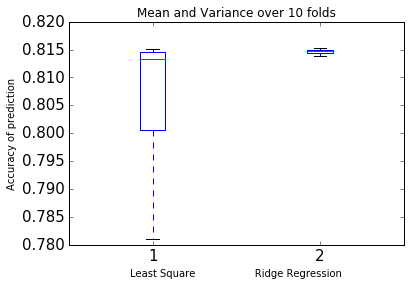

In [8]:
#Cross validation on Ridge and least squares
k_folds = 10
f1, w_CV_rid = cross_validation_ridge(y_train, x_train, best_lamb, k_folds, seed)
w_CV_LS, re, rt = cross_validation_LS(y_train, x_train, k_folds, seed)

#Compute accuracy for each fold
f1_CV_rid = []
f1_CV_LS = []
#Ridge Regression
print("cross folds: ridge")
for i in range(0, w_CV_rid.shape[0]):
    y_pred_rid = predict_labels(w_CV_rid[i], tx_test_fifth)
    y_pred_rid = np.reshape(y_pred_rid, (len(y_pred_rid), 1))
    f1_rid = sum(abs(y_test-y_pred_rid))/(2*len(y_pred_rid))
    print("{j}th fold: {a} accuracy".format(j=i+1, a=1-f1_rid))
    f1_CV_rid.append(1-f1_rid)
    
#Least Squares
print("cross folds: LS")
for i in range(0, w_CV_LS.shape[0]):
    y_pred_LS = predict_labels(w_CV_LS[i], tx_test_fifth)
    y_pred_LS = np.reshape(y_pred_LS, (len(y_pred_LS), 1))
    f1_LS = sum(abs(y_test-y_pred_LS))/(2*len(y_pred_LS))
    print("{j}th fold: {a} accuracy".format(j=i+1, a=1-f1_LS))
    f1_CV_LS.append(1-f1_LS)
    
f1_CV_LS = np.reshape(f1_CV_LS, (len(f1_CV_LS), 1))
f1_CV_rid = np.reshape(f1_CV_rid, (len(f1_CV_rid), 1))


plt.boxplot([f1_CV_LS, f1_CV_rid])
plt.title('Mean and Variance over 10 folds')
plt.xlabel("Least Square                   Ridge Regression")
plt.ylabel("Accuracy of prediction")

# Ridge Regression on polynomial degree 9 and feature combinations

the best lmabda is 1.1768119524349992e-05 with [ 0.81523077]


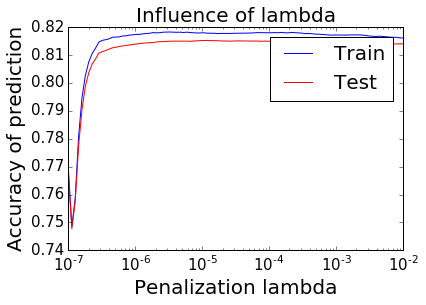

In [9]:
#***** POLYNOMIAL AND FEATURE COMBINATION
#************ POWER 9 **********************

#Let's replace the -999 by Nan to avoid computation while computing the power 3
x_nan = x.copy()
np.putmask(x_nan, x_nan==-999, np.nan)
degree = 9
x_pow9 = np.zeros((x_nan.shape[0], degree*x_nan.shape[1]))

#Let's build a matrix using a polynomial basis function (power 5)
for column in range(0,x_nan.shape[1]):
    x_pow9[:, column] = x_nan[:, column]
    for deg in range(1,degree):
        x_pow9[:, column + deg*x_nan.shape[1]] = np.multiply(x_nan[:, column], x_pow9[:, column + (deg-1)*x_nan.shape[1]])
#Combine important features together        
x_pow9 = combinations(x_pow9, [0], [1,2,6,7,])
x_pow9 = combinations(x_pow9, [2], [6,7])
x_pow9 = combinations(x_pow9, [3], [6,9,19,21,23,29])
x_pow9 = combinations(x_pow9, [4], [5,6])
x_pow9 = combinations(x_pow9, [5], [6])
x_pow9 = combinations(x_pow9, [6], [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29])
x_pow9 = combinations(x_pow9, [9], [10,13,16,19,21,23,26,29])
x_pow9 = combinations(x_pow9, [10], [13,16])
x_pow9 = combinations(x_pow9, [21], [23,26,29])
x_pow9 = combinations(x_pow9, [23], [26,29])
x_pow9 = combinations(x_pow9, [26], [29])
x_pow9 = combinations(x_pow9, [7], [8])

#put back -9 instead of Nan
x_pow9[np.isnan(x_pow9)]=-1

ratio = 0.35
seed = 2
y = np.reshape(y, (len(y), 1))
x_train, x_test, y_train, y_test = split_data(x_pow9, y, ratio, seed)

#tx_train_fifth, m, s = standardize(x_train)
#tx_test_fifth, m, s = standardize(x_test)

tx_train_pow9 = np.c_[np.ones((x_train.shape[0], 1)), x_train]
tx_test_pow9 = np.c_[np.ones((x_test.shape[0], 1)), x_test]
w = np.ones((tx_train_pow9.shape[1], 1))

#calculate accuracy for different lambdas (use cross_validation_ridge() for cross folds)
lambds = np.logspace(-7, -2, 100)
best_f1 = 0
best_lamb = 0
k_folds = 10
seed = 1
f1_tr = []
f1_te = []
for lamb in lambds:
    w_rid, r = ridge_regression(y_train, tx_train_pow9, lamb)
    y_pred_tr = predict_labels(w_rid, tx_train_pow9)
    y_pred_te = predict_labels(w_rid, tx_test_pow9)
    f1_rid_tr = 1-sum(abs(y_train-y_pred_tr))/(2*len(y_pred_tr))
    f1_rid_te = 1-sum(abs(y_test-y_pred_te))/(2*len(y_pred_te))
    f1_tr.append(f1_rid_tr)
    f1_te.append(f1_rid_te)
    if f1_rid_te > best_f1:
        best_lamb = lamb
        best_f1 = f1_rid_te

#Print and plot results
print("the best lmabda is {bl} with {f}".format(bl=best_lamb, f=best_f1))
plt.figure()
plt.semilogx(lambds, f1_tr)
plt.semilogx(lambds, f1_te, color='r')
plt.xlabel("Penalization lambda", fontsize=20)
plt.ylabel("Accuracy of prediction",  fontsize=20)
plt.legend(('Train', 'Test'),  fontsize=20)
plt.title("Influence of lambda", fontsize=20)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
plt.show()

cross folds: ridge
[ 0.81534769]
[ 0.81584]
[ 0.81569231]
[ 0.81591385]
[ 0.81550154]
[ 0.81678154]
[ 0.81615385]
[ 0.81516923]
[ 0.81510154]
[ 0.81564308]


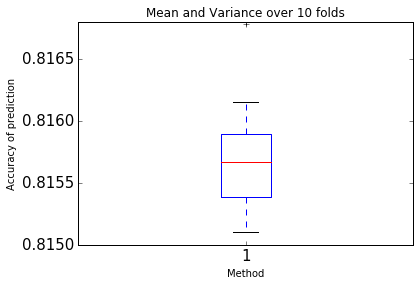

In [10]:
#Cross validation on Ridge and least squares
k_folds = 10

f1, w_CV_rid = cross_validation_ridge(y_train, x_train, best_lamb, k_folds, seed)

f1_CV_rid = []
f1_CV_LS = []
print("cross folds: ridge")
for i in range(0, w_CV_rid.shape[0]):
    y_pred_rid = predict_labels(w_CV_rid[i], tx_test_pow9)
    y_pred_rid = np.reshape(y_pred_rid, (len(y_pred_rid), 1))
    f1_rid = sum(abs(y_test-y_pred_rid))/(2*len(y_pred_rid))
    print(1-f1_rid)
    f1_CV_rid.append(1-f1_rid)

f1_CV_rid = np.reshape(f1_CV_rid, (len(f1_CV_rid), 1))

plt.boxplot(f1_CV_rid)
plt.title('Mean and Variance over 10 folds')
plt.xlabel("Method")
plt.ylabel("Accuracy of prediction")

# PCA

In [11]:
#max_iters = 1
#gamma = 0.4
#batch_size = 300
max_iter = 10
threshold = 1e-8
alpha = 0.001
lambd = 0.001
ratio = 0.05
losses = []

eigenvectors, eigenvalues, V = np.linalg.svd(x.T, full_matrices=False)
x_proj = np.dot(x, eigenvectors[:, 0:10])
y = np.reshape(y, (len(y), 1))

x_train, x_test, y_train, y_test = split_data(x_proj, y, ratio)
tx_train = np.c_[np.ones((y_train.shape[0], 1)), x_train]
tx_test = np.c_[np.ones((y_test.shape[0], 1)), x_test]
w = np.zeros((tx_train.shape[1], 1))

w_N, _ = learning_by_newton_method(y_train, tx_train, w, max_iters, alpha)

y_pred_N = predict_labels(w_N, tx_test)
y_pred_N = np.reshape(y_pred_N, (len(y_pred_N), 1))
f1_N = sum(abs(y_test-y_pred_N))/(2*len(y_pred_N))
print("Acuuracy of Newton Learning on PCA projection: ", 1-f1_N)

Acuuracy of Newton Learning on PCA projection:  [ 0.67781053]


## Generate predictions and save ouput in csv format for submission:

In [18]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download test data and supply path here 
_, X_test, ids_test = load_csv_data(DATA_TEST_PATH)

#Pepare testing matrix for the 9 degree poly + feature combination

#Let's replace the -999 by Nan to avoid computation while computing the power 3
x_nan_test = X_test.copy()
np.putmask(x_nan_test, x_nan_test==-999, np.nan)
degree = 9
x_TEST = np.zeros((x_nan_test.shape[0], degree*x_nan_test.shape[1]))

#Let's build a matrix using a polynomial basis function (power 5)
for column in range(0,x_nan_test.shape[1]):
    x_TEST[:, column] = x_nan_test[:, column]
    for deg in range(1,degree):
        x_TEST[:, column + deg*x_nan_test.shape[1]] = np.multiply(x_nan_test[:, column], x_TEST[:, column + (deg-1)*x_nan_test.shape[1]])
        
x_TEST = combinations(x_TEST, [0], [1,2,6,7,])
x_TEST = combinations(x_TEST, [2], [6,7])
x_TEST = combinations(x_TEST, [3], [6,9,19,21,23,29])
x_TEST = combinations(x_TEST, [4], [5,6])
x_TEST = combinations(x_TEST, [5], [6])
x_TEST = combinations(x_TEST, [6], [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29])
x_TEST = combinations(x_TEST, [9], [10,13,16,19,21,23,26,29])
x_TEST = combinations(x_TEST, [10], [13,16])
x_TEST = combinations(x_TEST, [21], [23,26,29])
x_TEST = combinations(x_TEST, [23], [26,29])
x_TEST = combinations(x_TEST, [26], [29])
x_TEST = combinations(x_TEST, [7], [8])

#put back -1 instead of Nan
x_TEST[np.isnan(x_TEST)]=-1

tx_TEST = np.c_[np.ones((x_TEST.shape[0], 1)), x_TEST]
print(tx_TEST.shape)

(568238, 325)


In [19]:
#Choose the weights needed to compute predictions
weights = w_CV_rid[0]
print(weights.shape)

(325,)


In [20]:
OUTPUT_PATH = '../data/ridgeA815.csv'
#Compute prediction
y_pred = predict_labels(weights, tx_TEST)
#Ouput CSV
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

In [21]:
# Delete train.csv such that github accepts push
os.remove('../data/test.csv')